In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Preprocessing the data

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

from tqdm import tqdm

def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        #class_num = 1 if label == 'PNEUMONIA' else 0
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object

In [ ]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

100%|██████████| 9/9 [00:00<00:00, 80.58it/s]


In [ ]:
def preprocess_data(x, y, img_size):
    x = np.array(x, dtype=np.float32) / 255
    x = x.reshape(-1, img_size, img_size, 1)
    y = np.array(y)
    return x, y

x_train, y_train = zip(*train)
x_val, y_val = zip(*val)
x_test, y_test = zip(*test)

x_train, y_train = preprocess_data(x_train, y_train, img_size)
x_val, y_val = preprocess_data(x_val, y_val, img_size)
x_test, y_test = preprocess_data(x_test, y_test, img_size)

# Initial model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-03 19:19:48.290988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746299988.536562      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746299988.612588      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-03 19:20:03.366290: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,308,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,327,361 (20.32 MB)

 Trainable params: 5,327,361 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=12,
    validation_data=(x_val, y_val),
    batch_size=32
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 600ms/step - accuracy: 0.8041 - loss: 0.5646 - val_accuracy: 0.8125 - val_loss: 0.4702
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 0.9595 - loss: 0.1047 - val_accuracy: 0.8750 - val_loss: 0.2695
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - accuracy: 0.9744 - loss: 0.0711 - val_accuracy: 0.7500 - val_loss: 0.4316
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 580ms/step - accuracy: 0.9792 - loss: 0.0594 - val_accuracy: 0.8125 - val_loss: 0.2301
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.9821 - loss: 0.0494 - val_accuracy: 0.8125 - val_loss: 0.3612
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.9850 - loss: 0.0410 - val_accuracy: 0.7500 - val_loss: 0.4623
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 572ms/step - accuracy: 0.9897 - loss: 0.0280 - val_accuracy: 0.9375 - val_loss: 0.1186
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 572ms/step - accuracy: 0.9866 - loss: 

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
results = model.evaluate(x_test, y_test, return_dict=True)
print(results)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.4667 - loss: 5.6097
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4667 - loss: 5.6097
{'accuracy': 0.7115384340286255, 'loss': 3.0182995796203613}
Test Accuracy: 71.15%


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

predictions=model.predict(x_test)
predictions = (predictions > 0.5).astype("int32").reshape(-1)

predictions[:15]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.69      0.99      0.81       390
   Normal (Class 1)       0.97      0.24      0.38       234

           accuracy                           0.71       624
          macro avg       0.83      0.62      0.60       624
       weighted avg       0.79      0.71      0.65       624



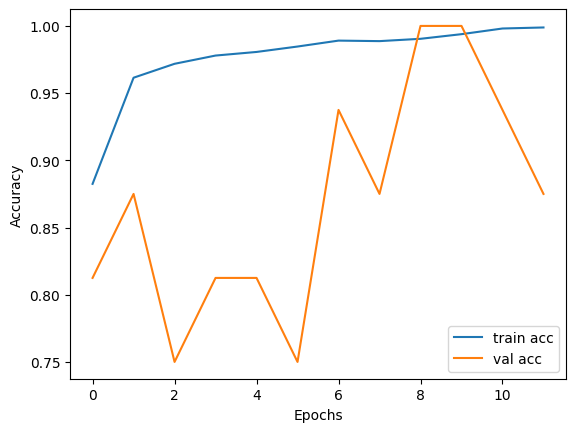

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Optimized model

In [ ]:
optimized_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimized_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimized_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,801 (18.42 MB)

 Trainable params: 4,828,353 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from keras.callbacks import EarlyStopping

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    restore_best_weights=True
)

history = optimized_model.fit(
    x_train, y_train,
    epochs=12,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks = [early_stopping]
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 848ms/step - accuracy: 0.9042 - loss: 0.8264 - val_accuracy: 0.5000 - val_loss: 30.3487
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 858ms/step - accuracy: 0.9464 - loss: 0.1606 - val_accuracy: 0.5000 - val_loss: 26.3854
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 852ms/step - accuracy: 0.9652 - loss: 0.1049 - val_accuracy: 0.5000 - val_loss: 12.2840
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - accuracy: 0.9705 - loss: 0.0916 - val_accuracy: 0.6875 - val_loss: 0.9638
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 844ms/step - accuracy: 0.9734 - loss: 0.0739 - val_accuracy: 0.6250 - val_loss: 1.6274
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - accuracy: 0.9812 - loss: 0.0512 - val_accuracy: 0.9375 - val_loss: 0.2056
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 829ms/step - accuracy: 0.9802 - loss: 0.0518 - val_accuracy: 0.8750 - val_loss: 0.4903
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 818ms/step - accuracy: 0.982

In [ ]:
loss, accuracy = optimized_model.evaluate(x_test, y_test)
results = optimized_model.evaluate(x_test, y_test, return_dict=True)
print(results)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.7256 - loss: 1.4254
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.7256 - loss: 1.4254
{'accuracy': 0.8333333134651184, 'loss': 0.8430556058883667}
Test Accuracy: 83.33%


In [ ]:
predictions=optimized_model.predict(x_test)
predictions = (predictions > 0.5).astype("int32").reshape(-1)

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.81      0.96      0.88       390
   Normal (Class 1)       0.91      0.62      0.73       234

           accuracy                           0.83       624
          macro avg       0.86      0.79      0.81       624
       weighted avg       0.85      0.83      0.82       624

